In [1]:
import numpy as np
import nibabel as nib
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn as nn
import pystrum
# import neurite as ne
from monai.losses import (
    GlobalMutualInformationLoss,
    BendingEnergyLoss,
    DiffusionLoss)
from monai.transforms import BorderPad

2024-07-26 17:52:07.386662: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-26 17:52:07.455790: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-26 17:52:07.483278: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-26 17:52:07.489239: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-26 17:52:07.518913: I tensorflow/core/platform/cpu_feature_guar

In [2]:
grid = pystrum.pynd.ndutils.bw_grid(vol_shape=(100, 100), spacing=11)

In [3]:
angle = np.pi/8 * np.random.uniform(-1/2, 1/2)
transform = torch.Tensor( [[[0.99*np.cos(angle), -np.sin(angle), 0.1],
                           [np.sin(angle), 0.9*np.cos(angle), 0.06]]])
b, c, w, h = 1, 1, 200, 200
warping = F.affine_grid(transform, size=(b, c, h, w), align_corners=True)
warped = F.grid_sample(torch.Tensor(grid)[None, None], warping, mode="bilinear", align_corners=True)


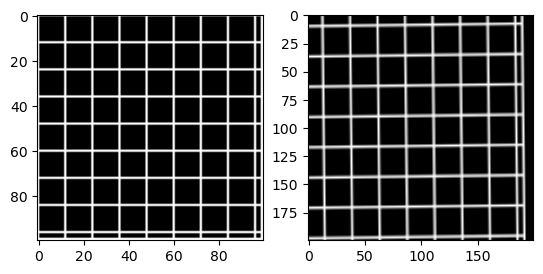

In [4]:
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(grid, cmap="gray")
ax[1].imshow(warped[0,0], cmap="gray")
plt.show()

### Classical image Registration

In [5]:
# Toy data
n = 224
x = torch.arange(n)
y = torch.arange(n)

sigmax = 1.5
sigmay = 3
X1 = (x-n/2) / (sigmax*np.sqrt(n))
X2 = (x-n/4) / (sigmay*np.sqrt(n)) 
Y1 = (y-n/2) / (sigmay*np.sqrt(n))
Y2 = (y-n/2) / (sigmax*np.sqrt(n))

I = torch.exp(-X1.view(1, n)**2-Y1.view(n, 1)**2) + torch.exp(-X2.view(1, n)**2-Y2.view(n, 1)**2)
image = I.view(1, 1, n, n)

In [58]:
class Deformation(nn.Module):
    """Class implementing affine transform of an image (rotation, small shear and small translation)"""
    
    def __init__(self, angle=np.pi/4, dx=0.05, dy=-0.05):
        super(Deformation, self).__init__()
        if angle is not None:
            self.angle = angle
            self.affine_transform = nn.Parameter(torch.Tensor( 
                                        [[[0.99*np.cos(self.angle), -np.sin(self.angle), dx],
                                       [np.sin(self.angle), 0.9*np.cos(self.angle), dy]]]))
        else:
            self.affine_transform = nn.Parameter(torch.Tensor(
                                        [[[1, 0, 0.],
                                          [0, 1, 0.]]]))

        print(self.affine_transform)
    
    def forward(self, x):
        b, c, h, w = x.shape
        grid = F.affine_grid(self.affine_transform, size=(b, c, h, w), align_corners=True)
        warped = F.grid_sample(x, grid, mode="bilinear", align_corners=True)
        return warped, grid

In [151]:
img = plt.imread("brain.jpg")
img = img[::3,::3]
img = img[None,None]
img = torch.Tensor(img)
# img = image


In [152]:
img.shape

torch.Size([1, 1, 429, 400])

In [153]:
# transform = BorderPad(spatial_border=[0, 10, 10])
# img = transform(img)


In [156]:
angle = np.pi/8 * np.random.uniform(-1, 1)
rot = Deformation(angle=angle, dx=0.0, dy=0.0)
m_image, _ = rot(img)
m_image = 255-m_image

# m_image = transform(m_image)

Parameter containing:
tensor([[[ 0.9582,  0.2513,  0.0000],
         [-0.2513,  0.8711,  0.0000]]], requires_grad=True)


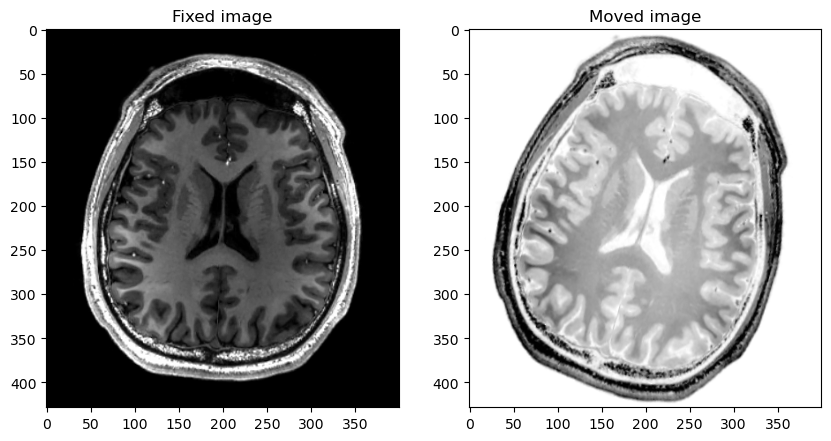

In [157]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(img[0, 0], cmap="gray")
# ax[0].axis('off')
ax[0].set_title("Fixed image")
ax[1].imshow(m_image[0, 0].detach().numpy(), cmap="gray")
# ax[1].axis('off')
ax[1].set_title("Moved image")
plt.show()

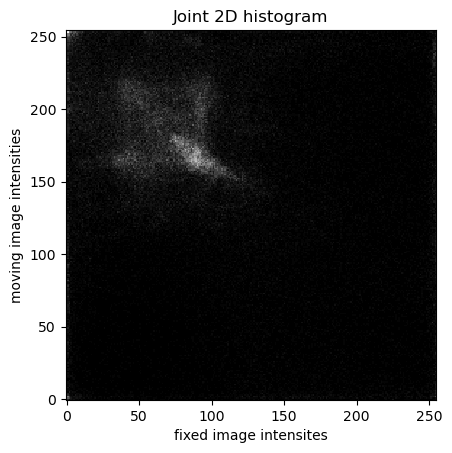

In [158]:
x = img.ravel()
y = m_image.detach().ravel()
# plt.plot(x, y, marker="o", alpha=0.1)
# plt.show()
hist, xedges, yedges = np.histogram2d(x, y, bins=255)
plt.imshow(hist.T, cmap="gray", origin='lower', interpolation='nearest', vmin=0, vmax=50)
plt.title("Joint 2D histogram")
plt.xlabel("fixed image intensites")
plt.ylabel("moving image intensities")
plt.show()

In [159]:
m_image.min(), m_image.max()

(tensor(0., grad_fn=<MinBackward1>), tensor(255., grad_fn=<MaxBackward1>))

In [160]:
reg = Deformation(angle=None)
m_image, _ = rot(img)
m_image= 255-m_image
pred, _ = reg(m_image)
m_image = m_image.detach()
optimizer = torch.optim.Adam(params=reg.parameters(), lr=1e-2)
criterion = torch.nn.L1Loss() #torch.nn.MSELoss()
criterion = GlobalMutualInformationLoss(kernel_type="b-spline")

Parameter containing:
tensor([[[1., 0., 0.],
         [0., 1., 0.]]], requires_grad=True)


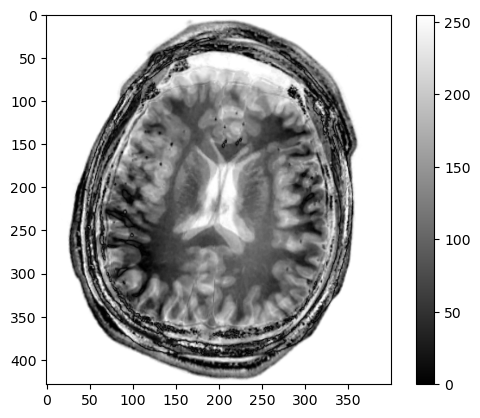

In [161]:
plt.imshow(torch.abs(img-m_image)[0, 0], cmap="gray")
plt.imshow(torch.abs(img[0,0] - m_image[0,0]), cmap="gray")
plt.colorbar()

In [162]:
def dice_loss(x, y):
    return 1 - (((2*x*y).sum()+1e-3) / (x.sum() + y.sum()+1e-3)) 
energy_loss = BendingEnergyLoss()

In [163]:
N_ITER = 400
losses = []
for i in tqdm(range(N_ITER)):
    optimizer.zero_grad()
    pred, ddf = reg(m_image) #.requires_grad_(True)
    loss = criterion(pred, img) #+ dice_loss(pred, img) #GlobalMutualInformationLoss()(pred, img)
    # loss+= energy_loss(ddf.permute(0, -1, 1, 2)) #dice_loss(pred, img) 
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

100%|██████████| 400/400 [01:35<00:00,  4.19it/s]


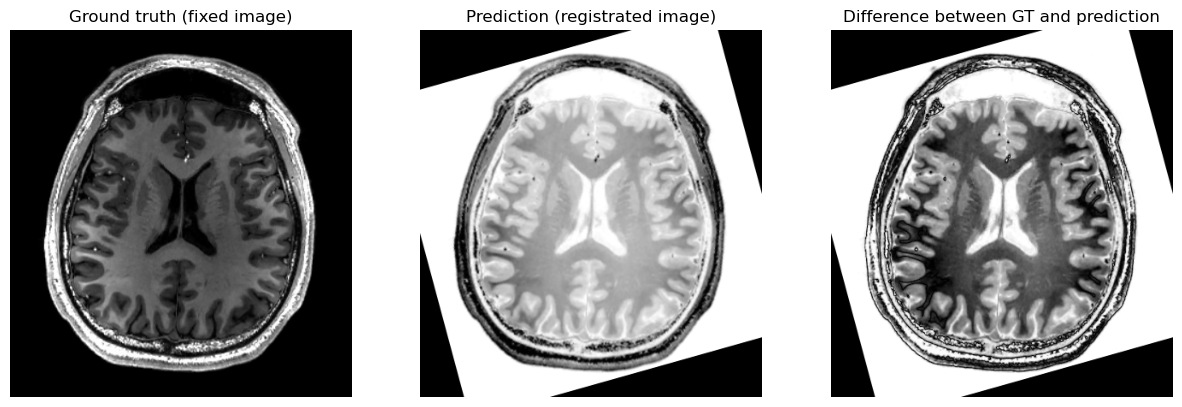

In [164]:
pred, _ = reg(m_image)
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
ax[0].imshow(img[0, 0], cmap="gray")
ax[0].axis('off')
ax[0].set_title("Ground truth (fixed image)")
ax[1].imshow(pred[0, 0].detach(), cmap="gray")
ax[1].axis('off')
ax[1].set_title("Prediction (registrated image)")
ax[2].imshow(torch.abs(img-pred.detach())[0, 0], cmap="gray")
ax[2].axis('off')
ax[2].set_title("Difference between GT and prediction")
plt.show()

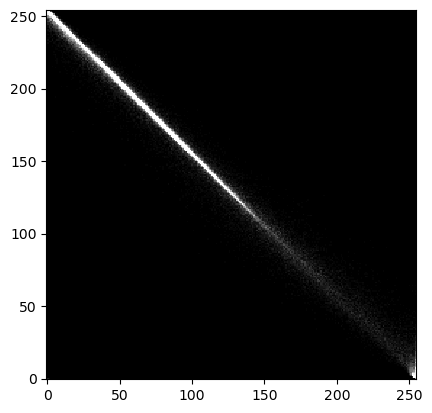

In [165]:
x = img.ravel()
y = pred.detach().ravel()
# plt.plot(x, y, ls="", marker="o", alpha=0.1)
# plt.show()
hist, xedges, yedges = np.histogram2d(x, y, bins=255)
plt.imshow(hist.T, cmap="gray", origin='lower', interpolation='nearest', vmin=0, vmax=50)
plt.show()

In [166]:
print("Absolute error : {:.3f}".format(float(torch.abs(img-pred.detach()).mean() / torch.abs(img).mean())))

Absolute error : 2.899


In [167]:
t = list(rot.parameters())[0].data
tinv = list(reg.parameters())[0].data
T = torch.eye(3)
Tinv = torch.eye(3)
 
Tinv[:2] = tinv
T[:2] = t

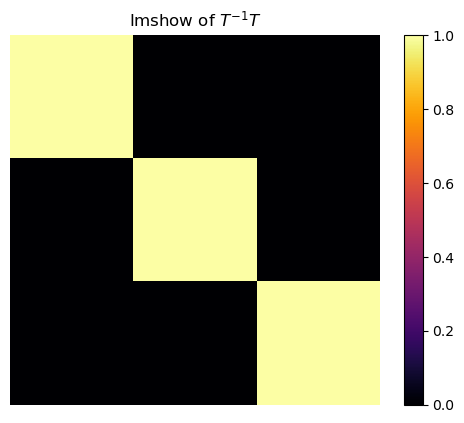

In [168]:
plt.imshow(Tinv@T, cmap="inferno")
plt.title("Imshow of $T^{-1}T$")
plt.axis("off")
plt.colorbar()
plt.show()

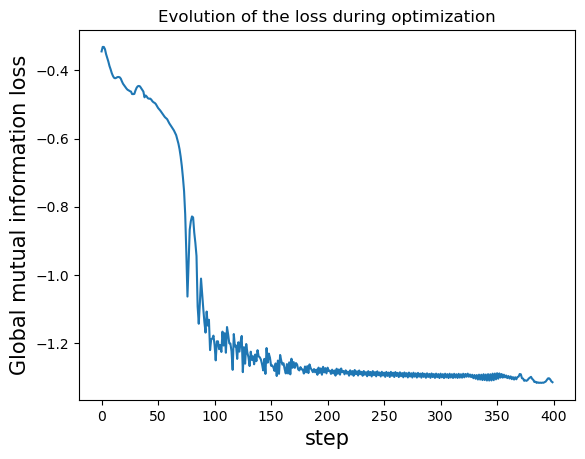

In [169]:
plt.plot(losses)
plt.title("Evolution of the loss during optimization")
plt.xlabel("step", fontsize=15)
plt.ylabel("Global mutual information loss", fontsize=15)
plt.show()

### Multimodal registration by Mutual Information maximization

In [69]:
t1_img = nib.load("mni_icbm152_nlin_sym_09a_nifti/mni_icbm152_nlin_sym_09a/mni_icbm152_t1_tal_nlin_sym_09a.nii.gz")
t1_data = t1_img.get_fdata()
t2_img = nib.load("mni_icbm152_nlin_sym_09a_nifti/mni_icbm152_nlin_sym_09a/mni_icbm152_t2_tal_nlin_sym_09a.nii.gz")
t2_data = t2_img.get_fdata() 

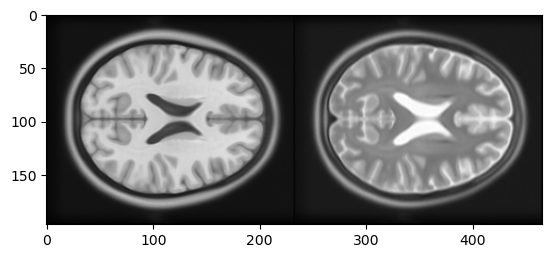

In [70]:
t1_slice = t1_data[:, :, 94]
t2_slice = t2_data[:, :, 94]
plt.imshow(np.hstack((t1_slice, t2_slice)), cmap="gray")
plt.show()

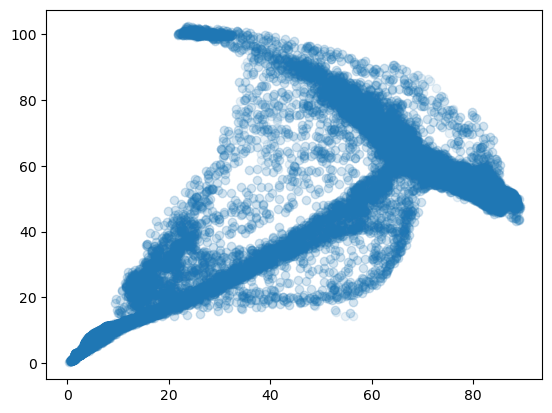

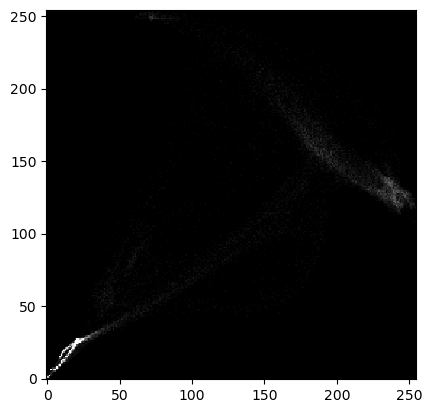

In [71]:
t1_slice = torch.Tensor(t1_slice[None, None])
t2_slice = torch.Tensor(t2_slice[None, None])
x = t1_slice.ravel()
y = t2_slice.ravel()
plt.plot(x, y, ls="", marker="o", alpha=0.1)
plt.show()
hist, xedges, yedges = np.histogram2d(x, y, bins=255)
plt.imshow(hist.T, cmap="gray", origin='lower', interpolation='nearest', vmin=0, vmax=100)
plt.show()

In [72]:
N_ITER = 1000
reg = Deformation(angle=None)
optimizer = torch.optim.Adam(params=reg.parameters(), lr=1e-3)
criterion = torch.nn.L1Loss() #
criterion = torch.nn.MSELoss()
# criterion = GlobalMutualInformationLoss()
diffusion_loss = DiffusionLoss()

Parameter containing:
tensor([[[1., 0., 0.],
         [0., 1., 0.]]], requires_grad=True)


In [73]:
t1_slice.shape

torch.Size([1, 1, 197, 233])

In [74]:
transform = torch.Tensor( [[[1., 0, 0.1],
                           [0, 1., 0.0]]])
warping = F.affine_grid(transform, size=(1, 1, 197, 233), align_corners=True)
t2_m = F.grid_sample(t2_slice, warping, mode="bilinear", align_corners=True)

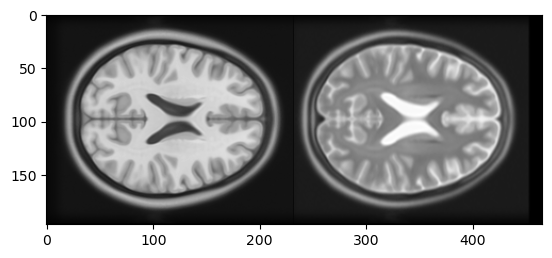

In [75]:
t1_slice.shape
t2_m = F.grid_sample(t2_slice, warping, mode="bilinear", align_corners=True)
t2_m = t2_m.detach()
plt.imshow(np.hstack((t1_slice[0,0], t2_m[0,0])), cmap="gray")
plt.show()

In [76]:
losses = []
# best_loss = torch.inf
for i in tqdm(range(N_ITER)):
    optimizer.zero_grad()
    pred, ddf = reg(t2_m) #.requires_grad_(True)
    loss = dice_loss(pred, t1_slice) #dice_loss(pred, img) 
    # loss += diffusion_loss(ddf.permute(0, -1, 1, 2))
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

100%|██████████| 1000/1000 [00:01<00:00, 702.43it/s]


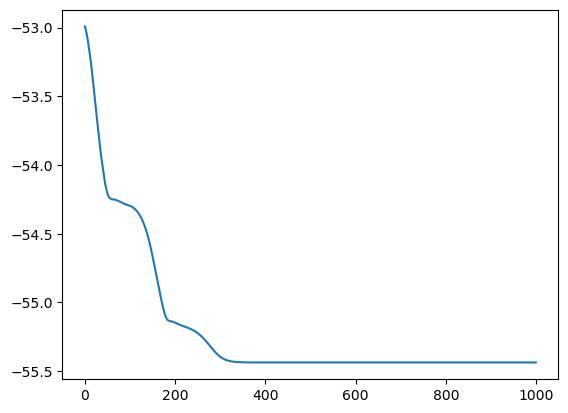

In [79]:
plt.plot(losses)
plt.show()

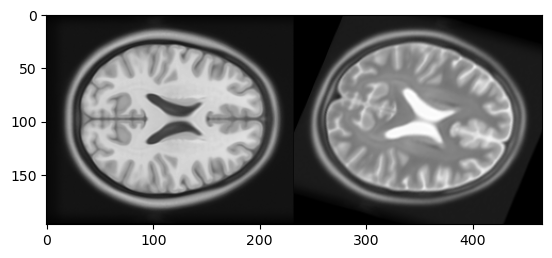

In [80]:
plt.imshow(np.hstack((t1_slice[0,0], pred.detach().numpy()[0,0])), cmap="gray")
plt.show()

In [22]:
print(list(reg.parameters()))

[Parameter containing:
tensor([[[ 1.0694e+00, -3.8575e-05, -4.3790e-02],
         [ 6.6636e-04,  1.0128e+00,  3.0295e-05]]], requires_grad=True)]


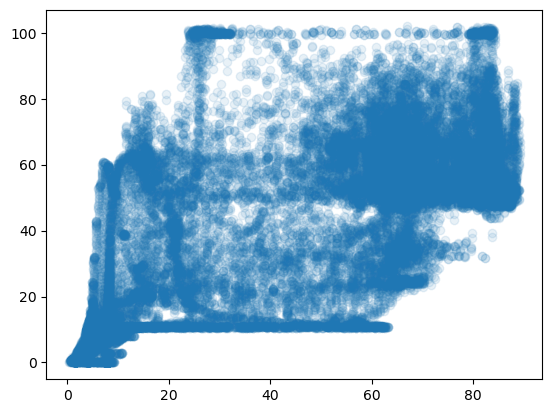

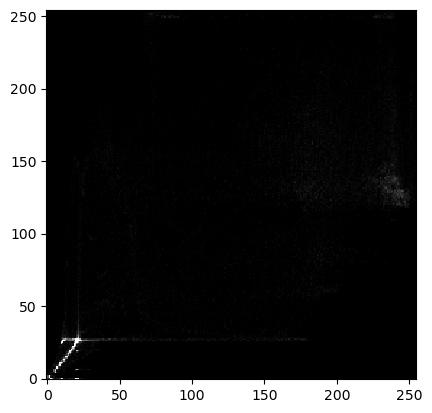

In [91]:
x = t1_slice.ravel()
y = pred.detach().ravel()
plt.plot(x, y, ls="", marker="o", alpha=0.1)
plt.show()
hist, xedges, yedges = np.histogram2d(x, y, bins=255)
plt.imshow(hist.T, cmap="gray", origin='lower', interpolation='nearest', vmin=0, vmax=100)
plt.show()